In [273]:
from SPARQLWrapper import SPARQLWrapper, JSON
from datetime import datetime
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from cdlib import algorithms

In [274]:
def plot_dist(G):
    M = nx.to_scipy_sparse_matrix(G)
    xmin = min([d[1] for d in G.degree()])
    indegrees = M.sum(0).A[0]
    degree = np.bincount(indegrees)
    fit = powerlaw.Fit(np.array(degree)+1, fit_method='KS')#, xmin=xmin, xmax=max(degree)-xmin,discrete=True)
    
    
    fig = plt.figure(figsize=(16, 6)) 
    """ Plot Distribution """
    plt.subplot(1, 3, 1)
    plt.plot(range(len(degree)),degree,'b.')   
    plt.loglog()
    plt.xlim((min(degree), max(degree)))
    plt.xlabel('Degree')
    plt.ylabel('P(k)')


    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf()
    plt.xlabel("Degree")
    plt.ylabel('CDF')

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.plot_ccdf()
    plt.ylabel('CCDF')
    plt.xlabel('Degree')
    plt.tight_layout()
    plt.show()

In [275]:
def similarita(voti_dep1, voti_dep2):
    uguali = np.sum((voti_dep1 == voti_dep2) & (voti_dep1 != 0) ) # volte in cui hanno votato la stessa  ed erano entrambi presenti

    diversi = np.sum((voti_dep1 != voti_dep2) & (voti_dep1 != 0) & (voti_dep2 != 0) ) # volte in cui hanno votato diversamente ed erano entrambi presenti
    
    if uguali == 0:
        sim = 0
    else:
        sim = uguali/(uguali+diversi)
    return sim

# Load dataset and pre-process, dropping noise rows

In [276]:
y2021 = pd.read_csv('xviii-2021.csv')
y2021.shape

(660, 1749)

In [277]:
nan_count = y2021.isnull().sum(axis=1)
p = 0.8
l = len(y2021.columns[4:])
df = y2021.drop(nan_count[nan_count >= p*l].index, axis = 0)

df.shape


(450, 1749)

In [278]:
#mapping to categorical values
dizionario_espressioni = {'Assente': np.float64(0), 'Favorevole': np.float64(1), 'Non ha votato': np.float64(0), 'Contrario': np.float64(3), 'Astensione': np.float64(4), 'In missione': np.float64(0)}
for i in df.columns[4:]:
    df[i] = df[i].map(dizionario_espressioni)

df = df.replace(np.nan, 0)

In [279]:
df.head()

,Parlamentare,id,Partito,dataIngresso,449002,449004,449005,449001,449003,450003,...,607015,608003,608009,608005,608006,608007,608008,608002,608004,608001
0,BASINI GIUSEPPE,200049,LEGA,2018-03-27,1.0,1.0,1.0,1.0,1.0,3.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BERSANI PIER LUIGI,300026,MISTO,2018-03-23,3.0,1.0,1.0,3.0,1.0,1.0,...,3.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,FRANCESCHINI DARIO,300246,PD,2018-03-27,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,MILANATO LORENA,300296,FI,2018-03-27,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,ORSINI ANDREA GIORGIO FELICE MARIA,300299,FI,2018-03-27,1.0,1.0,1.0,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [280]:
df.reset_index(inplace= True, drop = True)
indici = []
for i in range(df.shape[0]):
    if np.count_nonzero(df.iloc[i,4:]) < 0.2*(df.shape[1]-4):
        indici.append(i)


df.drop(indici, axis = 0, inplace = True)
df.shape

(297, 1749)

# Extract party alignment for each voting

In [281]:
#works only with dataframes like ours
def alignment_parties(df):
    col = df.columns[4:].to_list()
    col.append('Partito')
    parties_alignment = pd.DataFrame()
    party = df.groupby('Partito')
    for i in party: # party[0] nome partito, party[1] dataframe
        a = np.apply_along_axis(statistics.mode, axis = 0, arr= i[1])[4:].tolist()
        a.append(i[0])
        parties_alignment = pd.concat([parties_alignment, pd.DataFrame(a).T], axis = 0)

    parties_alignment.columns = col
    return parties_alignment


In [282]:
alignment = alignment_parties(df)
alignment

,449002,449004,449005,449001,449003,450003,450004,450005,450002,450001,...,608003,608009,608005,608006,608007,608008,608002,608004,608001,Partito
0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,...,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-SI
0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,...,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,CI
0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,4.0,4.0,...,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,FDI
0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,4.0,4.0,...,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,FI
0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,...,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,IPF-IC
0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,...,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,IV-IC'E'
0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,4.0,4.0,...,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,LEGA
0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,...,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,M5S
0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MISTO
0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,...,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,PD


## Partisan discipline

In [283]:
discipline = []
for index, row in df.iterrows():
    p = alignment[alignment['Partito'] == row['Partito']]
    c = 0
    for i in p.drop('Partito', axis = 1).columns:
        if row[i] == np.float64(p[i][0]):
            c+=1
    
    discipline.append(c/(len(p.columns) - 1))

df['discipline'] = discipline

In [284]:
print(df['discipline'].mean(), df['discipline'].std())

0.6484925665441424 0.12928316750772803


# Graph based on similarity

In [285]:
df

,Parlamentare,id,Partito,dataIngresso,449002,449004,449005,449001,449003,450003,...,608003,608009,608005,608006,608007,608008,608002,608004,608001,discipline
0,BASINI GIUSEPPE,200049,LEGA,2018-03-27,1.0,1.0,1.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.492264
1,BERSANI PIER LUIGI,300026,MISTO,2018-03-23,3.0,1.0,1.0,3.0,1.0,1.0,...,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.540401
5,CIRIELLI EDMONDO,300319,FDI,2018-03-27,1.0,1.0,1.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.488252
11,GIACHETTI ROBERTO,300480,IV-IC'E',2019-09-19,3.0,1.0,1.0,3.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.834384
12,BARELLI PAOLO,300497,FI,2018-03-27,1.0,0.0,0.0,1.0,0.0,3.0,...,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.543266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,BALDINI MARIA TERESA,308181,FI,2018-03-27,1.0,1.0,1.0,1.0,1.0,3.0,...,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.757593
443,PAOLIN GIUSEPPE,308381,LEGA,2018-03-27,1.0,1.0,1.0,1.0,1.0,3.0,...,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.660172
444,ALBANO LUCIA,308421,FDI,2018-03-27,1.0,1.0,1.0,1.0,1.0,3.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.484814
447,AVOSSA EVA,308521,PD,2018-03-27,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.545559


In [286]:
m = np.array(df[df.columns[4:df.shape[1]-1]])
m.shape

(297, 1745)

In [287]:
A = np.zeros((len(m),len(m))) #inizializzo matrice a 0
i=0
j=0
for i in range(len(m)):
    for j in range(len(m)):
        A[i,j] = similarita(m[i],m[j])

In [288]:
unique_scores, counts = np.unique(A, return_counts=True)
distribution = dict(zip(unique_scores, counts / np.sum(counts)))

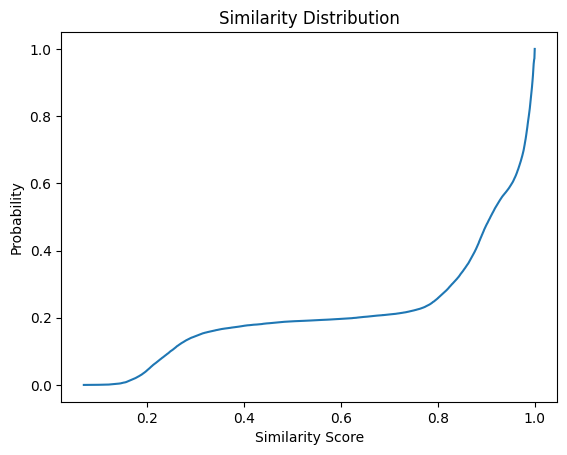

In [289]:
scores = list(distribution.keys())
probabilities = np.cumsum(list(distribution.values()))

plt.plot(scores, probabilities)
plt.xlabel('Similarity Score')
plt.ylabel('Probability')
plt.title('Similarity Distribution')
plt.show()

297
44253
43956
297


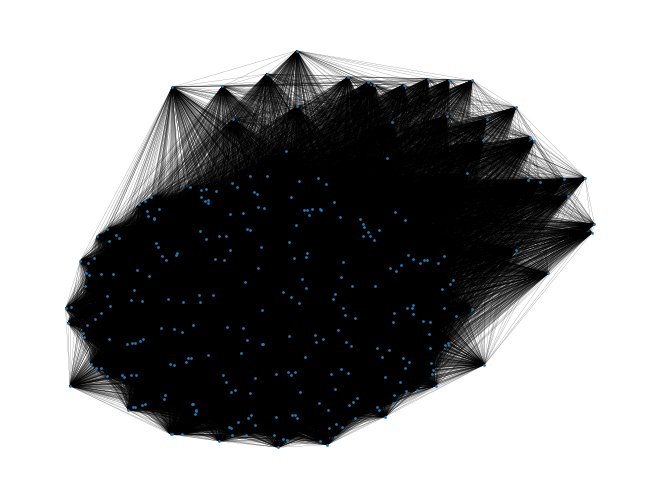

In [290]:
G = nx.from_numpy_matrix(A)

print(G.number_of_nodes())
print(G.number_of_edges())
G.remove_edges_from(nx.selfloop_edges(G))
print(G.number_of_edges())
print(G.number_of_nodes())

nx.draw(G, node_size = 1, width = 0.1)

43956
35292


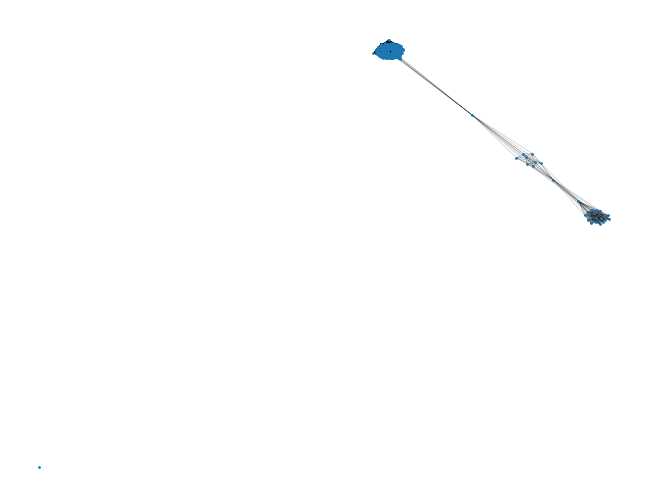

In [291]:
F = G.copy()
threshold = 0.6
print(F.number_of_edges())
F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < threshold])
print(F.number_of_edges())

nx.draw(F, node_size = 1, width = 0.1)
plt.show()

Degree Distribution Analysis

In [292]:
sum(dict(G.degree()).values())/float(len(G)) #avg degree

296.0

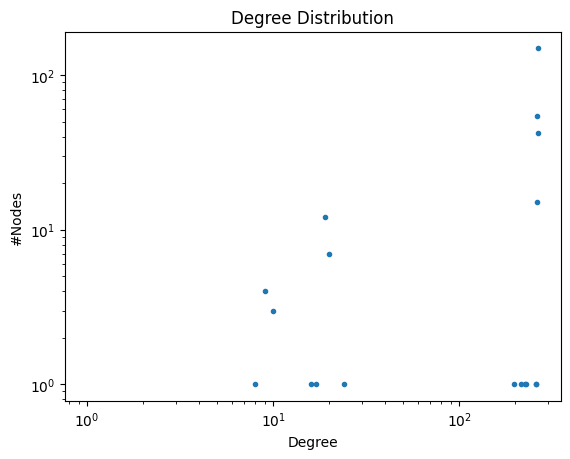

In [293]:
hist = nx.degree_histogram(F)   
plt.plot(range(0, len(hist)), hist, '.')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

connected components

In [294]:
print(nx.number_connected_components(F))
comps = list(nx.connected_components(F)) # get a list of connected components (for decreasing size)


2


path analysis

In [295]:
nx.average_shortest_path_length(F.subgraph(comps[0])) #giant component

1.5600320659642692

In [296]:
nx.diameter(F.subgraph(comps[0])) # we compute the diameter on the giant component

5

Clustering coefficient

In [297]:
nx.average_clustering(F) # compute the global clustering coefficient

0.9841269530443625

Density

In [298]:
nx.density(F)

0.8028938028938029

# ER

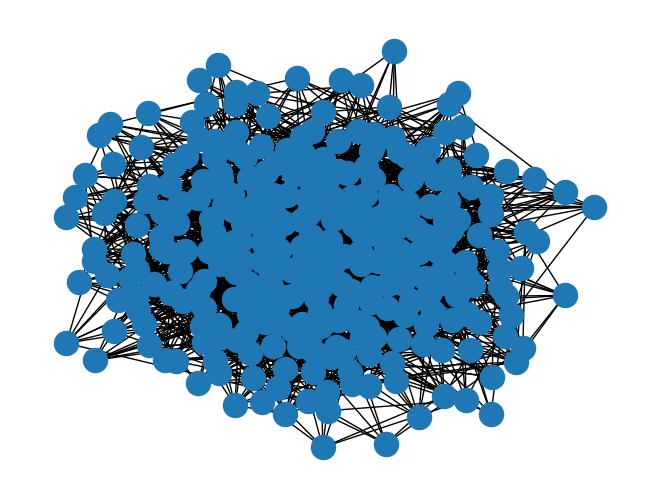

In [299]:
# network generators 1 (random graphs)
p = 0.05 # cambiare p 
er = nx.erdos_renyi_graph(F.number_of_nodes(), p)
nx.draw(er)

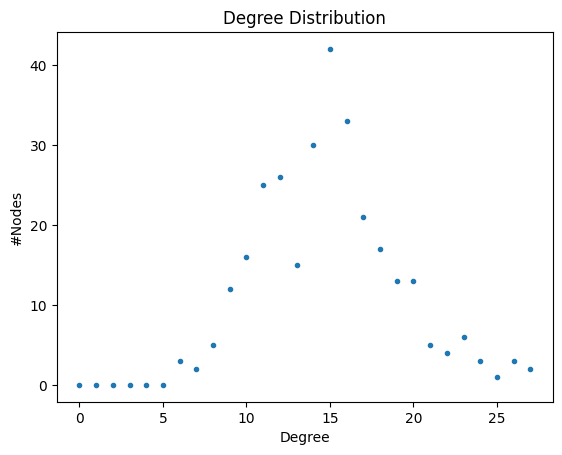

In [300]:
hist = nx.degree_histogram(er)
    
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.show()

# BA

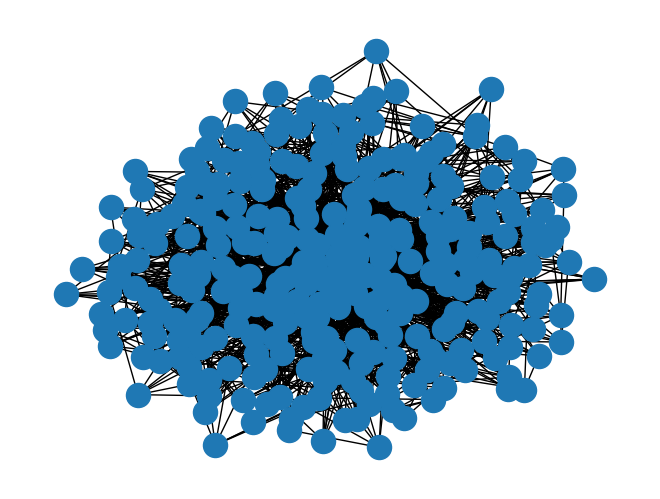

In [301]:
m = 7  # number of links each node establishes once joining the network
ba = nx.barabasi_albert_graph(F.number_of_nodes(), m)
nx.draw(ba)

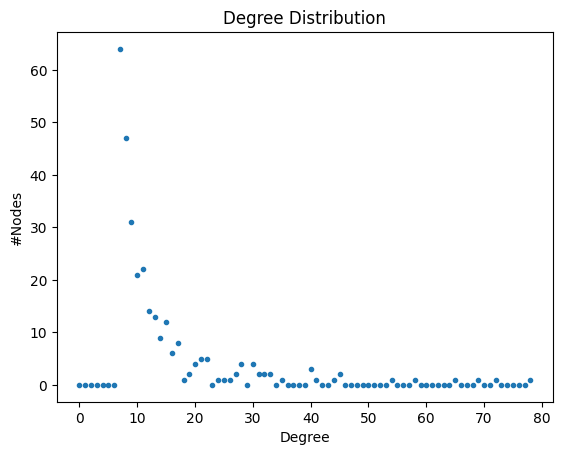

In [302]:
hist = nx.degree_histogram(ba)
    
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.show()

# Prova

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
43956
43956
43939
43668
42031
39462
37539
36656
36195
35867
35607
35459
35290
35014
34708
34192
32590
29154
22991
17794
1108


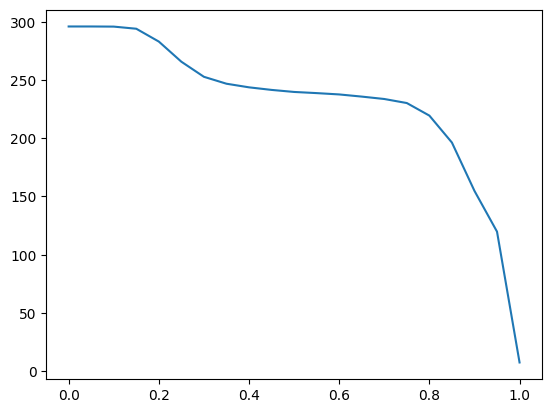

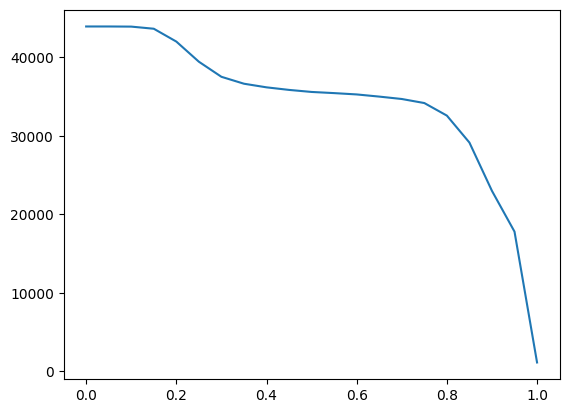

In [303]:
thresholds = np.linspace(0,1, 21)
print(thresholds)
avg_deg = []
n_edg = [] #number of edges

for threshold in thresholds:
    F = G.copy()
    #print(F.number_of_edges())
    F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < threshold])
    print(F.number_of_edges())
    deg = sum(dict(F.degree()).values())/float(len(G)) #avg degree
    avg_deg.append(deg)
    n_edg.append(F.number_of_edges())
plt.plot(thresholds, avg_deg)
plt.show()
#plt.plot(thresholds, n_edg)
#plt.show()

# Communities

43956
35607


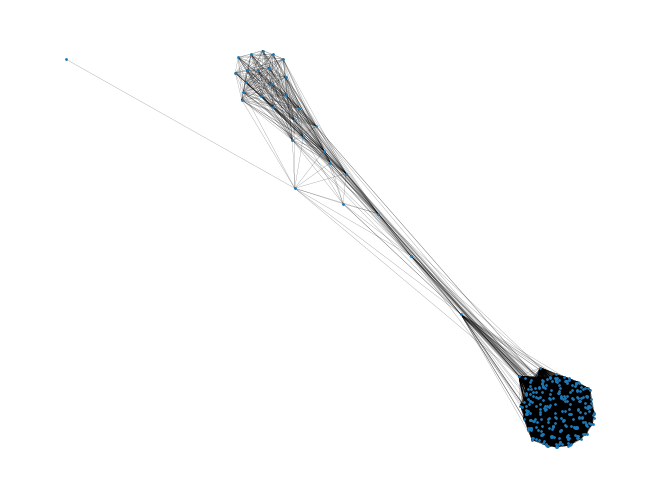

In [321]:
F = G.copy()
threshold = 0.5
print(F.number_of_edges())
F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < threshold])
print(F.number_of_edges())

nx.draw(F, node_size = 1, width = 0.1)
plt.show()

In [322]:
louvain = algorithms.louvain(F)

In [323]:
louvain.communities

[[1,
  3,
  6,
  8,
  9,
  13,
  14,
  16,
  18,
  19,
  20,
  21,
  22,
  24,
  27,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  42,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  54,
  55,
  56,
  57,
  58,
  59,
  61,
  62,
  63,
  64,
  66,
  67,
  68,
  69,
  71,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  86,
  87,
  88,
  89,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  109,
  110,
  112,
  115,
  116,
  117,
  118,
  119,
  120,
  122,
  123,
  127,
  128,
  129,
  130,
  132,
  136,
  137,
  140,
  141,
  142,
  146,
  147,
  148,
  149,
  151,
  152,
  155,
  156,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  174,
  175,
  176,
  177,
  178,
  179,
  181,
  182,
  184,
  185,
  189,
  190,
  192,
  193,
  194,
  195,
  196,
  197,
  203,
  207,
  209,
  211,
  216,
  217,
  219,
  220,
  221,
  222,
  224,
  227,
  228,
  229,
  230,
  231,
  232,
  23

In [324]:
louvain.average_internal_degree(summary=False)

[164.0, 100.0, 21.870967741935484]

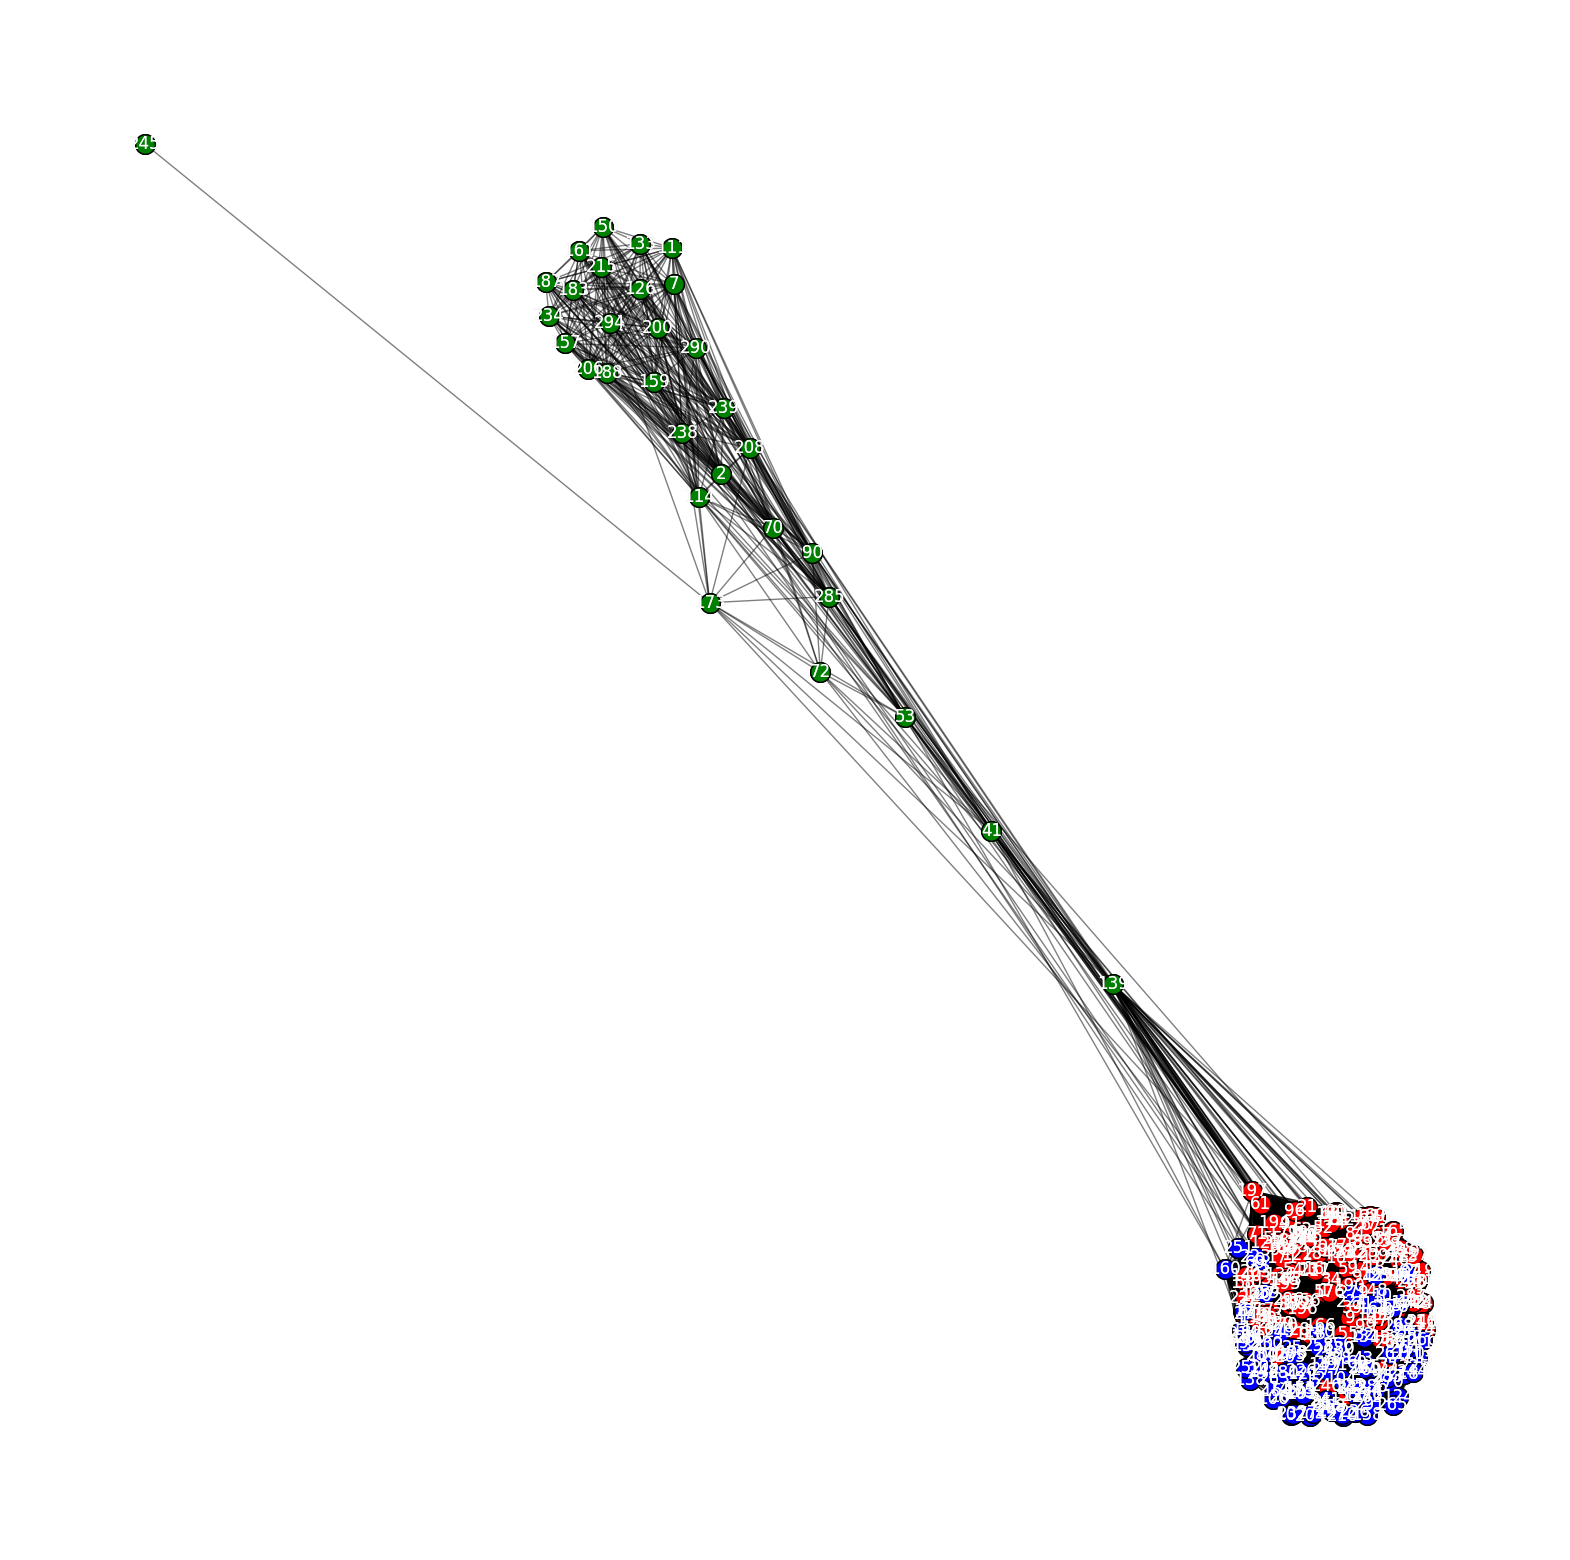

In [325]:
from cdlib import viz

pos = nx.spring_layout(F)
viz.plot_network_clusters(F, louvain, pos, figsize=(20, 20), plot_labels=True)